In [1]:
#First, all the necessary libraries are imported

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
#The dataset file is read using read_csv function from pandas library
df= pd.read_csv('./2014.csv', skiprows=[0])
df.shape

(235631, 151)

In [3]:
#Count of number of missing values
df.isna().sum().sum()

13298613

In [4]:
#Printing all  the features of the data

print(list(df.columns))

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq',

In [5]:
#There are so many features of this dataset but we are interested in loan status.
#After running this, we can see that there are 7 types of loan status.

df.loan_status.value_counts()

Fully Paid            169973
Charged Off            38170
Current                25413
Late (31-120 days)      1253
In Grace Period          549
Late (16-30 days)        266
Default                    5
Name: loan_status, dtype: int64

In [6]:
'''Here, we are interested in two types of loan status i.e. those who paid the loan and those who were charged'''

df = df.loc[(df['loan_status'].isin(['Fully Paid', 'Charged Off']))]
df.shape

(208143, 151)

In [7]:
'''Looking at the shape of the data, we can see that there is almost half the data than original
data and the same number of features
Now, we peform general data processing steps first'''

#1. Remove features associated with 90% missing values.
''' 
We use pandas built in method 'isnull()' to find rows associated with missing values.
Then ,we sum them up to count for each feature. Then these features are removed and data is 
sorted for further analysis.
'''
missing_df = df.isnull().sum(axis = 0).sort_values().to_frame('missing_value').reset_index()
miss_2000 = list(missing_df[missing_df.missing_value >= 190000]['index'])
print(len(miss_2000))

53


In [8]:
'''Above we can see that there are 52 features which have 200000 missing values.
Now, we use pandas 'drop' method to remove these features.
In this function we set the “inplace” option to 'True', which removes these features
from original data frame df without returning anything.
'''
df.drop(miss_2000, axis = 1, inplace = True)
df.shape

(208143, 98)

In [9]:
#2. Remove constant features
#Now, we remove features that have a unique single value.We cant analyze anything beacause its variance is zero.

def find_constant_features(dataFrame):
    const_features = []
    for column in list(dataFrame.columns):
        if dataFrame[column].unique().size < 2:
            const_features.append(column)
    return const_features
const_features = find_constant_features(df)
print(const_features)

['pymnt_plan', 'out_prncp', 'out_prncp_inv', 'policy_code', 'application_type', 'hardship_flag', 'disbursement_method']


In [10]:
'''In the above code, we create a function “find_constant_features” to identify constant features.
The function goes through each feature and sees if it has less than two unique values. 
If so, the features are added to the constant feature list. We can also find out constant feature 
looking at the variance or standard deviation. If the feature has zero variance or standard deviation, 
we are sure that the feature has single unique value. The print statement shows that five features have
single unique value. So we remove them using “inplace” option true below.
'''
df.drop(const_features, axis = 1, inplace = True)
df.shape

(208143, 91)

In [11]:
#3. Remove duplicate features.
'''Duplicate features are those have the same value in multiple features with the same/different name.
To find out the duplicate features, we use this function.
'''
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []
    for t, v in groups.items():
        cs = frame[v].columns
        vs = frame[v]
        lcs = len(cs)
        for i in range(lcs):
            ia = vs.iloc[:,i].values
            for j in range(i+1, lcs):
                ja = vs.iloc[:,j].values
                if np.array_equal(ia, ja):
                    dups.append(cs[i])
                    break
    return dups
duplicate_cols = duplicate_columns(df)
print(duplicate_cols)

['loan_amnt']


In [12]:
df.iloc[0:5, 0: 10]

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title
0,38098114,15000.0,15000.0,15000.0,60 months,12.39%,336.64,C,C1,MANAGEMENT
1,36805548,10400.0,10400.0,10400.0,36 months,6.99%,321.08,A,A3,Truck Driver Delivery Personel
2,37842129,21425.0,21425.0,21425.0,60 months,15.59%,516.36,D,D1,Programming Analysis Supervisor
4,37662224,7650.0,7650.0,7650.0,36 months,13.66%,260.20,C,C3,Technical Specialist
5,37822187,9600.0,9600.0,9600.0,36 months,13.66%,326.53,C,C3,Admin Specialist


In [13]:
#We have, duplicate columns, if we check the dataset, we can see that loan_amnt, funded_amnt and funded_amnt_inv have same values
#So, we drop such columns as there is no need of duplicates
df.drop(['funded_amnt','funded_amnt_inv'], axis=1, inplace=True)

#4. Remove Duplicate rows.
'''Here, we remove all the duplicate rows using pandas built-in function 'drop_duplicates()' '''
df.drop_duplicates(inplace= True)

In [14]:
#Now, we have performed some basic processing, the shape of the data is:
df.shape

(208143, 89)

In [15]:
def plot_feature(col_name, isContinuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if isContinuous:
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name)
    plt.xticks(rotation = 90)
# Plot with loan status
    if isContinuous:
        sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by Loan Status')
    else:
        data = df.groupby(col_name)['loan_status'].value_counts(normalize=True).to_frame('proportion').reset_index()        
        sns.barplot(x = col_name, y = 'proportion', hue= "loan_status", data = data, saturation=1, ax=ax2)
        ax2.set_ylabel('Loan fraction')
        ax2.set_title('Loan status')
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()

In [16]:
"""
The plot_feature function accepts two parameters; the first one is the feature name and the second one is the
boolean variable: whether the feature is continuous or categorical. If the feature is continuous then function
plot two subplots: (1) the distribution of the feature and (2) the two boxplots based on loan_status class.
On the other hand, if the feature is categorical, then the first subplot is count plot and the second subplot is
based on the group_by loan_status classes.
"""

df.iloc[0:5, 0: 10]

,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership
0,38098114,15000.0,60 months,12.39%,336.64,C,C1,MANAGEMENT,10+ years,RENT
1,36805548,10400.0,36 months,6.99%,321.08,A,A3,Truck Driver Delivery Personel,8 years,MORTGAGE
2,37842129,21425.0,60 months,15.59%,516.36,D,D1,Programming Analysis Supervisor,6 years,RENT
4,37662224,7650.0,36 months,13.66%,260.20,C,C3,Technical Specialist,< 1 year,RENT
5,37822187,9600.0,36 months,13.66%,326.53,C,C3,Admin Specialist,10+ years,RENT


In [17]:
#For Column loan_amnt:
len(df.loan_amnt.value_counts())

1284

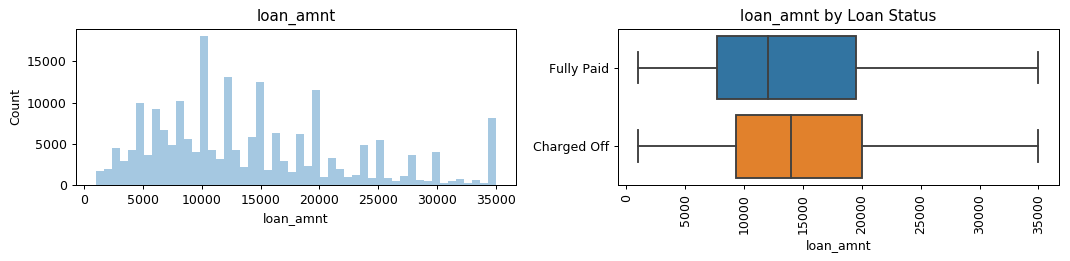

In [18]:
plot_feature('loan_amnt', True)

In [19]:
#All loans are not unique. Some loans appear many times and some do not. So, the company has certain range to lend.

#For Column term

df.term.value_counts()

 36 months    161820
 60 months     46323
Name: term, dtype: int64

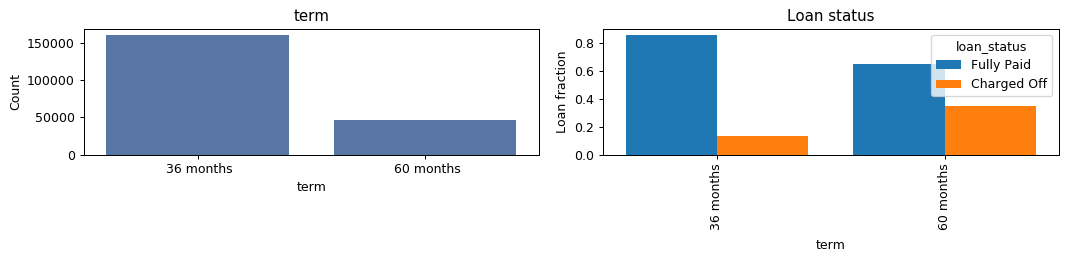

In [20]:
plot_feature('term', False)

In [21]:
#For Column Interest rate i.e. int_rate

df.int_rate = df.int_rate.str.replace('%', '').astype(np.float32)
len(df.int_rate.value_counts())

88

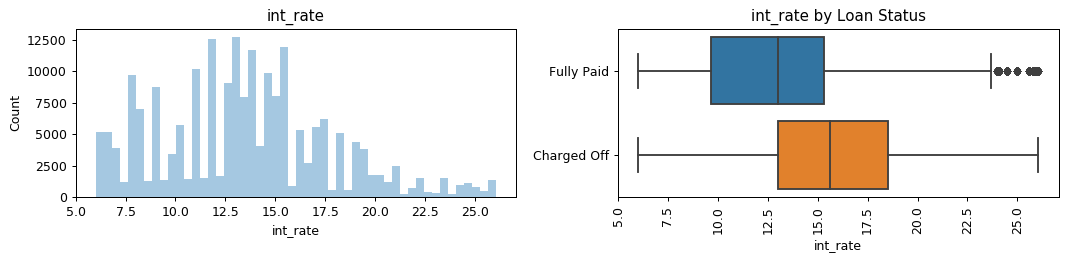

In [22]:
plot_feature('int_rate', True)

In [23]:
#From above graph we can see that those who were charged off, had to pay high interest rate

#For Column Grade and sub-grade

df.grade.value_counts()

B    57807
C    57335
A    35569
D    34818
E    16101
F     5150
G     1363
Name: grade, dtype: int64

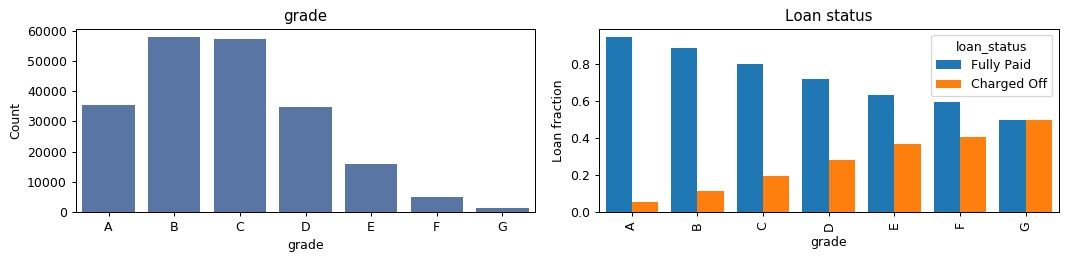

In [24]:
#From above code, we know that sub-grade has 35 unique categories
plot_feature('grade', False)

In [25]:
df.sub_grade.value_counts()
len(df.sub_grade.value_counts())

35

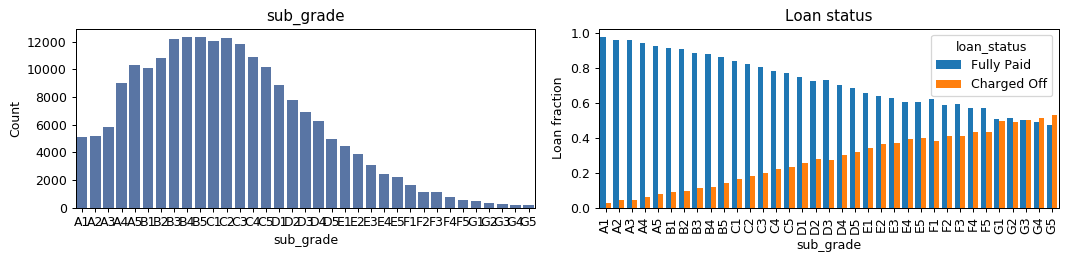

In [26]:
plot_feature('sub_grade', False)

In [27]:
#From above comparisons, we can see that sub-grade and grade both have same distribution and shape.
# But sub_grade has more categories or more data

#For Column: Employment title

len(df.emp_title.value_counts())

67799

In [28]:
#From above value, we can conclude that emp_title has too many unique values, which may not be good for prediction
#   So, we remove this feature along with other extra non-relavent features.

features_to_be_removed=[]
features_to_be_removed.extend(['emp_title', 'id'])

In [29]:
#Now, we check next 10 Columns or features using iloc function

df.iloc[0:5, 6: 22]

,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line
0,C1,MANAGEMENT,10+ years,RENT,78000.0,Source Verified,Dec-2014,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,235xx,VA,12.03,0.0,Aug-1994
1,A3,Truck Driver Delivery Personel,8 years,MORTGAGE,58000.0,Not Verified,Dec-2014,Charged Off,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,937xx,CA,14.92,0.0,Sep-1989
2,D1,Programming Analysis Supervisor,6 years,RENT,63800.0,Source Verified,Dec-2014,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,658xx,MO,18.49,0.0,Aug-2003
4,C3,Technical Specialist,< 1 year,RENT,50000.0,Source Verified,Dec-2014,Charged Off,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,850xx,AZ,34.81,0.0,Aug-2002
5,C3,Admin Specialist,10+ years,RENT,69000.0,Source Verified,Dec-2014,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,077xx,NJ,25.81,0.0,Nov-1992


In [30]:
#For Column emp_length
df.emp_length.value_counts()

10+ years    68690
2 years      18289
3 years      16328
< 1 year     16212
1 year       13075
4 years      12078
5 years      11598
7 years      11580
6 years      10528
8 years      10486
9 years       8298
Name: emp_length, dtype: int64

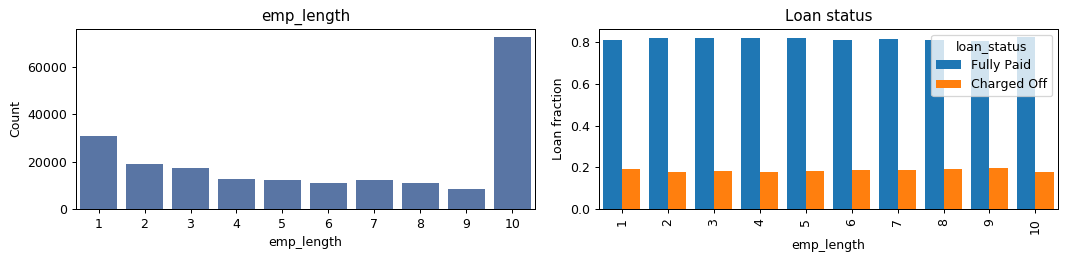

In [31]:
#The column emp_length has NaN values, so to remove it we fill it with previous column values.

df.emp_length.fillna(method='ffill',inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['emp_length'] = df['emp_length'].astype(int)
plot_feature('emp_length', False)

In [32]:
#Feature Home Ownership
df.home_ownership.value_counts()

MORTGAGE    103778
RENT         83830
OWN          20534
ANY              1
Name: home_ownership, dtype: int64

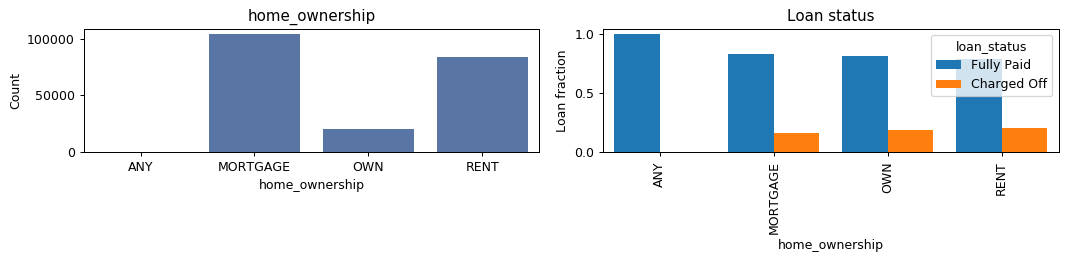

In [33]:
plot_feature('home_ownership', False)

In [34]:
#Feature verification status

df.verification_status.value_counts()

Source Verified    83053
Not Verified       66638
Verified           58452
Name: verification_status, dtype: int64

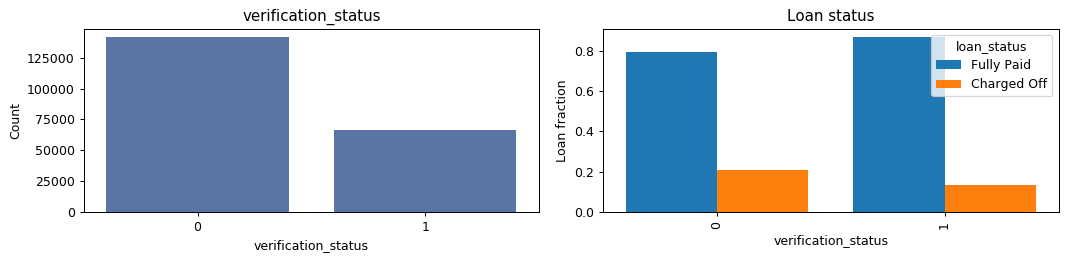

In [35]:
df.verification_status = df.verification_status.map(lambda x: 1 if x == 'Not Verified' else 0)
plot_feature('verification_status', False)

In [36]:
#In above graph, we can see from right plot that those applicants whose source was verified are more likely to be charged off.


#Feature issue_d


df.issue_d.value_counts()

Oct-2014    33699
Jul-2014    25974
Nov-2014    21186
Apr-2014    17140
May-2014    17133
Aug-2014    16780
Jun-2014    15207
Mar-2014    14988
Jan-2014    14464
Feb-2014    13945
Sep-2014     9344
Dec-2014     8283
Name: issue_d, dtype: int64

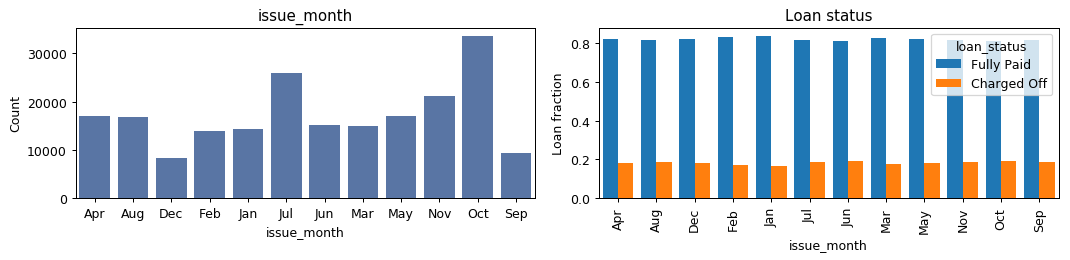

In [37]:
#We want to keep our data independent of year.So,we remove years and consider only month

df['issue_month'] = pd.Series(df.issue_d).str.replace(r'-\d+', '')
plot_feature('issue_month', False)

In [38]:
#Feature Purpose
df.purpose.value_counts()

debt_consolidation    125523
credit_card            48987
home_improvement       11452
other                   9563
major_purchase          3493
medical                 2178
small_business          2048
car                     1705
moving                  1248
vacation                1134
house                    687
renewable_energy         117
wedding                    8
Name: purpose, dtype: int64

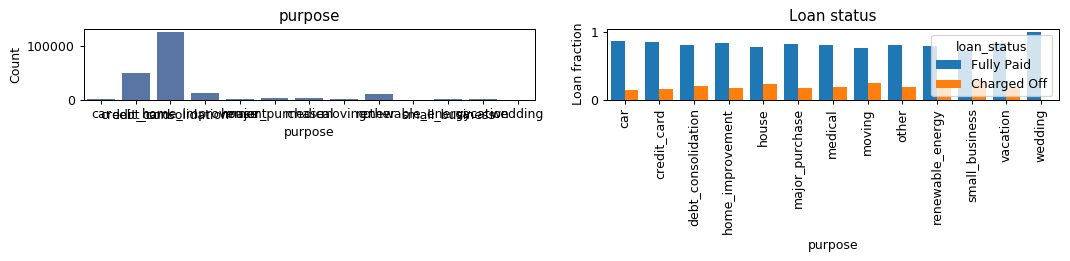

In [39]:
plot_feature('purpose', False)

In [40]:
#Here, we can see who took loan for what purpose and which category of people paid full or were charged


#Feature addr_state

len(df.addr_state.value_counts())

49

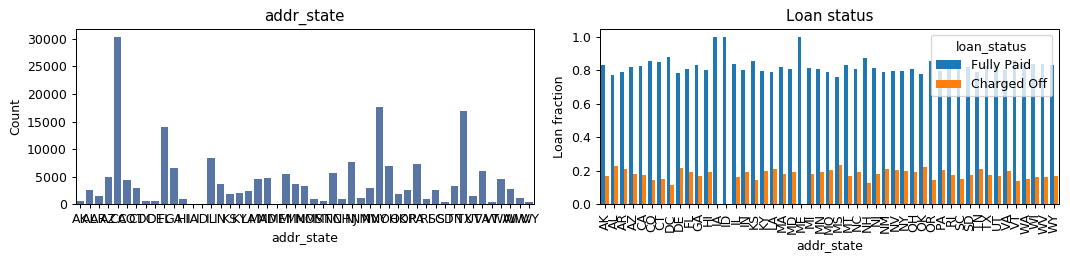

In [41]:
plot_feature('addr_state',False)

In [42]:
#If we look at the plot, we see that certain states applicants paid back more than others.

#Finally, removing remaining features
features_to_be_removed.extend(['url','title','zip_code'])

In [43]:
df.iloc[0:5, 20: 31]

,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util
0,0.0,Aug-1994,750.0,754.0,0.0,NaN,NaN,6.0,0.0,138008.0,29%
1,0.0,Sep-1989,710.0,714.0,2.0,42.0,NaN,17.0,0.0,6133.0,31.6%
2,0.0,Aug-2003,685.0,689.0,0.0,60.0,NaN,10.0,0.0,16374.0,76.2%
4,0.0,Aug-2002,685.0,689.0,1.0,NaN,NaN,11.0,0.0,16822.0,91.9%
5,0.0,Nov-1992,680.0,684.0,0.0,NaN,NaN,12.0,0.0,16388.0,59.4%


In [44]:
features_to_be_removed.extend(['issue_d','earliest_cr_line', 'mths_since_last_delinq', 'mths_since_last_record', 'inq_last_6mths', 
                               'mths_since_last_delinq', 'mths_since_last_record'])

In [45]:
df.iloc[0:5, 30: 41]

,revol_util,total_acc,initial_list_status,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d
0,29%,17.0,w,17392.37,17392.37,15000.00,2392.37,0.0,0.00,0.0000,Jun-2016
1,31.6%,36.0,w,6611.69,6611.69,5217.75,872.67,0.0,521.27,93.8286,Aug-2016
2,76.2%,35.0,w,25512.20,25512.20,21425.00,4087.20,0.0,0.00,0.0000,May-2016
4,91.9%,20.0,f,2281.98,2281.98,704.38,339.61,0.0,1237.99,222.8382,Aug-2015
5,59.4%,44.0,f,9973.43,9973.43,9600.00,373.43,0.0,0.00,0.0000,Apr-2015


In [46]:
df.revol_util = df.revol_util.str.replace('%','').astype(np.float32)
df.initial_list_status.value_counts()

w    105639
f    102504
Name: initial_list_status, dtype: int64

In [47]:
df.initial_list_status = df.initial_list_status.map(lambda x: 1 if x== 'w' else 0)
#plot_feature('initial_list_status',False)

In [48]:
features_to_be_removed.extend(['total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 
                               'total_rec_int', 'total_rec_late_fee'])

In [49]:
df.iloc[0:5, 41: 51]

,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,12017.81,Nov-2017,684.0,680.0,0.0,NaN,0.0,0.0,149140.0,184500.0
1,321.08,Feb-2017,564.0,560.0,0.0,59.0,0.0,0.0,162110.0,19400.0
2,17813.19,Dec-2017,704.0,700.0,0.0,74.0,0.0,0.0,42315.0,21500.0
4,17.70,Oct-2016,559.0,555.0,0.0,NaN,0.0,0.0,64426.0,18300.0
5,9338.58,Dec-2017,724.0,720.0,0.0,NaN,0.0,0.0,38566.0,27600.0


In [50]:
features_to_be_removed.extend(['recoveries', 'collection_recovery_fee', 'last_pymnt_d', 
                               'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high',
                               'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog'])

In [51]:
df.iloc[0:5, 51: 61]

,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl
0,5.0,29828.0,9525.0,4.7,0.0,0.0,103.0,244.0,1.0,1.0
1,7.0,9536.0,7599.0,41.5,0.0,0.0,76.0,290.0,1.0,1.0
2,4.0,4232.0,324.0,97.8,0.0,0.0,135.0,136.0,7.0,7.0
4,6.0,5857.0,332.0,93.2,0.0,0.0,137.0,148.0,8.0,8.0
5,8.0,3214.0,6494.0,69.2,0.0,0.0,183.0,265.0,23.0,3.0


In [52]:
features_to_be_removed.extend([ 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 
                              'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy', 
                               'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt'])

In [53]:
df.iloc[0:5, 61: 71]

,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl
0,0.0,47.0,NaN,NaN,NaN,0.0,1.0,4.0,1.0,2.0
1,1.0,5.0,42.0,1.0,42.0,4.0,6.0,9.0,7.0,18.0
2,0.0,7.0,60.0,7.0,60.0,1.0,3.0,4.0,3.0,12.0
4,0.0,17.0,NaN,3.0,NaN,0.0,1.0,4.0,1.0,4.0
5,0.0,24.0,NaN,17.0,NaN,0.0,4.0,7.0,5.0,16.0


In [54]:
features_to_be_removed.extend(['mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
                               'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
                               'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 
                               'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 
                               'num_accts_ever_120_pd'])

In [55]:
df.iloc[0:5, 71: 81]

,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq
0,8.0,5.0,9.0,4.0,6.0,0.0,0.0,0.0,4.0,100.0
1,2.0,14.0,32.0,9.0,17.0,0.0,0.0,0.0,4.0,83.3
2,16.0,5.0,18.0,4.0,10.0,0.0,0.0,0.0,2.0,91.4
4,12.0,4.0,8.0,4.0,11.0,0.0,0.0,0.0,2.0,100.0
5,17.0,8.0,26.0,7.0,12.0,0.0,0.0,0.0,3.0,100.0


In [56]:
features_to_be_removed.extend(['num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 
                               'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 
                               'num_rev_accts', 'num_rev_tl_bal_gt_0', 
                               'num_sats', 'num_tl_120dpd_2m'])

In [57]:
df.iloc[0:5, 81: 91]

,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,debt_settlement_flag,issue_month
0,0.0,0.0,0.0,196500.0,149140.0,10000.0,12000.0,N,Dec
1,14.3,0.0,0.0,179407.0,15030.0,13000.0,11325.0,N,Dec
2,100.0,0.0,0.0,57073.0,42315.0,15000.0,35573.0,N,Dec
4,100.0,0.0,0.0,82331.0,64426.0,4900.0,64031.0,N,Dec
5,60.0,0.0,0.0,52490.0,38566.0,21100.0,24890.0,N,Dec


In [58]:
features_to_be_removed.extend(['num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 
                               'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot_hi_cred_lim', 
                               'total_bal_ex_mort', 'total_bc_limit'])

In [59]:
df.iloc[0:5, 85:]

,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,debt_settlement_flag,issue_month
0,149140.0,10000.0,12000.0,N,Dec
1,15030.0,13000.0,11325.0,N,Dec
2,42315.0,15000.0,35573.0,N,Dec
4,64426.0,4900.0,64031.0,N,Dec
5,38566.0,21100.0,24890.0,N,Dec


In [60]:
df.debt_settlement_flag.value_counts()

N    205197
Y      2946
Name: debt_settlement_flag, dtype: int64

In [61]:
df.debt_settlement_flag = df.debt_settlement_flag.map(lambda x: 0 if x == 'N' else 1)
#plot_feature('debt_settlement_flag',False)

In [62]:
features_to_be_removed.extend(['debt_settlement_flag', 'total_il_high_credit_limit'])

In [63]:
#Now, after evaluating and checking all columns, we check the removed features

len(set(features_to_be_removed))

62

In [64]:
#So, we have 61 features or columns which need to be removed
print(features_to_be_removed)

['emp_title', 'id', 'url', 'title', 'zip_code', 'issue_d', 'earliest_cr_line', 'mths_since_last_delinq', 'mths_since_last_record', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev

In [65]:
#Finally we drop the above features
df_selected = df.drop(list(set(features_to_be_removed)), axis = 1)
df_selected.shape

(208143, 28)

In [66]:
#Lets check if there are missing values in the above features
df_dtypes = pd.merge(df_selected.isnull().sum(axis = 0).sort_values().to_frame('missing_value').reset_index(),
         df_selected.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')

df_dtypes.sort_values(['missing_value', 'feature_type'])

,index,missing_value,feature_type
19,emp_length,0,int32
4,initial_list_status,0,int64
16,verification_status,0,int64
23,int_rate,0,float32
0,loan_amnt,0,float64
1,pub_rec_bankruptcies,0,float64
2,mort_acc,0,float64
3,acc_open_past_24mths,0,float64
5,total_acc,0,float64
6,revol_bal,0,float64


In [67]:
#From above code, we see that 'desc' and 'revol_util' have missing values.
#Filling the 'revol_util' column's missing values with the mean
df_selected['revol_util']=df_selected['revol_util'].fillna(df_selected['revol_util'].mean())

In [68]:
#Lets check if there are missing values in the above features
df_dtypes = pd.merge(df_selected.isnull().sum(axis = 0).sort_values().to_frame('missing_value').reset_index(),
         df_selected.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')

df_dtypes.sort_values(['missing_value', 'feature_type'])

,index,missing_value,feature_type
4,initial_list_status,0,int64
17,verification_status,0,int64
6,revol_util,0,float32
24,int_rate,0,float32
20,emp_length,0,int32
0,loan_amnt,0,float64
1,pub_rec_bankruptcies,0,float64
2,mort_acc,0,float64
3,acc_open_past_24mths,0,float64
5,total_acc,0,float64


In [69]:
df_selected.shape

(208143, 28)

In [70]:
df_selected.iloc[0:5,:]

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,acc_open_past_24mths,mort_acc,pub_rec_bankruptcies,tax_liens,issue_month
0,15000.0,60 months,12.39,336.64,C,C1,10,RENT,78000.0,0,...,0.0,138008.0,29.000000,17.0,1,5.0,0.0,0.0,0.0,Dec
1,10400.0,36 months,6.99,321.08,A,A3,8,MORTGAGE,58000.0,1,...,0.0,6133.0,31.600000,36.0,1,7.0,1.0,0.0,0.0,Dec
2,21425.0,60 months,15.59,516.36,D,D1,6,RENT,63800.0,0,...,0.0,16374.0,76.199997,35.0,1,4.0,0.0,0.0,0.0,Dec
4,7650.0,36 months,13.66,260.20,C,C3,1,RENT,50000.0,0,...,0.0,16822.0,91.900002,20.0,0,6.0,0.0,0.0,0.0,Dec
5,9600.0,36 months,13.66,326.53,C,C3,10,RENT,69000.0,0,...,0.0,16388.0,59.400002,44.0,0,8.0,0.0,0.0,0.0,Dec


In [71]:
#Removing all extra strings from certain columns
df_selected.term = df_selected.term.str.replace('months', '').astype(np.int)

In [72]:
#Encoding
#Now, we encode few of the categorical features'''

df_selected.issue_month = df_selected.issue_month.astype("category", categories=np.unique(df_selected.issue_month)).cat.codes
df_selected.purpose = df_selected.purpose.astype("category", categories=np.unique(df_selected.purpose)).cat.codes
df_selected.home_ownership = df_selected.home_ownership.astype("category", categories = np.unique(df_selected.home_ownership)).cat.codes
df_selected.grade = df_selected.grade.astype("category", categories = np.unique(df_selected.grade)).cat.codes
df_selected.sub_grade = df_selected.sub_grade.astype("category", categories = np.unique(df_selected.sub_grade)).cat.codes
df_selected.addr_state = df_selected.addr_state.astype("category", categories = np.unique(df_selected.addr_state)).cat.codes
df_selected.loan_status = df_selected.loan_status.astype("category", categories=np.unique(df_selected.loan_status)).cat.codes

In [73]:
df_selected.iloc[0:5,:]

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,acc_open_past_24mths,mort_acc,pub_rec_bankruptcies,tax_liens,issue_month
0,15000.0,60,12.39,336.64,2,10,10,3,78000.0,0,...,0.0,138008.0,29.000000,17.0,1,5.0,0.0,0.0,0.0,2
1,10400.0,36,6.99,321.08,0,2,8,1,58000.0,1,...,0.0,6133.0,31.600000,36.0,1,7.0,1.0,0.0,0.0,2
2,21425.0,60,15.59,516.36,3,15,6,3,63800.0,0,...,0.0,16374.0,76.199997,35.0,1,4.0,0.0,0.0,0.0,2
4,7650.0,36,13.66,260.20,2,12,1,3,50000.0,0,...,0.0,16822.0,91.900002,20.0,0,6.0,0.0,0.0,0.0,2
5,9600.0,36,13.66,326.53,2,12,10,3,69000.0,0,...,0.0,16388.0,59.400002,44.0,0,8.0,0.0,0.0,0.0,2


In [74]:
df=df_selected

In [75]:
df.shape

(208143, 28)

In [76]:
df.describe()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,acc_open_past_24mths,mort_acc,pub_rec_bankruptcies,tax_liens,issue_month
count,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000,2.081430e+05,208143.000000,...,208143.000000,2.081430e+05,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000
mean,14226.581245,41.341289,13.493560,436.931913,1.802910,10.999476,6.140903,1.904152,7.416822e+04,0.320155,...,0.228583,1.595931e+04,54.946949,25.928578,0.507531,4.457008,1.821358,0.140922,0.055323,5.892953
std,8342.473020,9.983088,4.321523,250.857520,1.314001,6.479074,3.529690,0.944552,5.551229e+04,0.466537,...,0.612346,2.118639e+04,23.137184,11.947731,0.499944,2.881268,2.158408,0.384054,0.412135,3.411901
min,1000.000000,36.000000,6.000000,23.360000,0.000000,0.000000,1.000000,0.000000,3.000000e+03,0.000000,...,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8000.000000,36.000000,10.150000,255.040000,1.000000,6.000000,3.000000,1.000000,4.500000e+04,0.000000,...,0.000000,6.073000e+03,38.099998,17.000000,0.000000,2.000000,0.000000,0.000000,0.000000,3.000000
50%,12000.000000,36.000000,13.350000,375.490000,2.000000,10.000000,7.000000,2.000000,6.400000e+04,0.000000,...,0.000000,1.118800e+04,55.400002,24.000000,1.000000,4.000000,1.000000,0.000000,0.000000,6.000000
75%,20000.000000,36.000000,15.990000,574.750000,3.000000,15.000000,10.000000,3.000000,9.000000e+04,1.000000,...,0.000000,1.973200e+04,72.599998,33.000000,1.000000,6.000000,3.000000,0.000000,0.000000,9.000000
max,35000.000000,60.000000,26.059999,1409.990000,6.000000,34.000000,10.000000,3.000000,7.500000e+06,1.000000,...,63.000000,2.560703e+06,892.299988,156.000000,1.000000,53.000000,34.000000,12.000000,63.000000,11.000000


In [77]:
standardized_df=(df-df.min())/(df.max()-df.min())

In [78]:
standardized_df.describe()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,acc_open_past_24mths,mort_acc,pub_rec_bankruptcies,tax_liens,issue_month
count,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000,...,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000,208143.000000
mean,0.389017,0.222554,0.373366,0.298257,0.300485,0.323514,0.571211,0.634717,0.009493,0.320155,...,0.003628,0.006232,0.061580,0.155380,0.507531,0.084094,0.053569,0.011744,0.000878,0.535723
std,0.245367,0.415962,0.215468,0.180912,0.219000,0.190561,0.392188,0.314851,0.007405,0.466537,...,0.009720,0.008274,0.025930,0.077583,0.499944,0.054364,0.063483,0.032005,0.006542,0.310173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.205882,0.000000,0.206879,0.167081,0.166667,0.176471,0.222222,0.333333,0.005602,0.000000,...,0.000000,0.002372,0.042699,0.097403,0.000000,0.037736,0.000000,0.000000,0.000000,0.272727
50%,0.323529,0.000000,0.366401,0.253947,0.333333,0.294118,0.666667,0.666667,0.008137,0.000000,...,0.000000,0.004369,0.062087,0.142857,1.000000,0.075472,0.029412,0.000000,0.000000,0.545455
75%,0.558824,0.000000,0.498006,0.397648,0.500000,0.441176,1.000000,1.000000,0.011605,1.000000,...,0.000000,0.007706,0.081363,0.201299,1.000000,0.113208,0.088235,0.000000,0.000000,0.818182
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [79]:
lst=list((df['int_rate']-df['int_rate'].mean())/df['int_rate'].std())
df['norm_int_rate']=lst

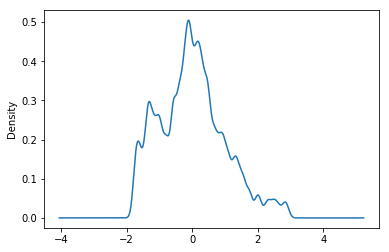

In [80]:
df.norm_int_rate.plot(kind='kde')

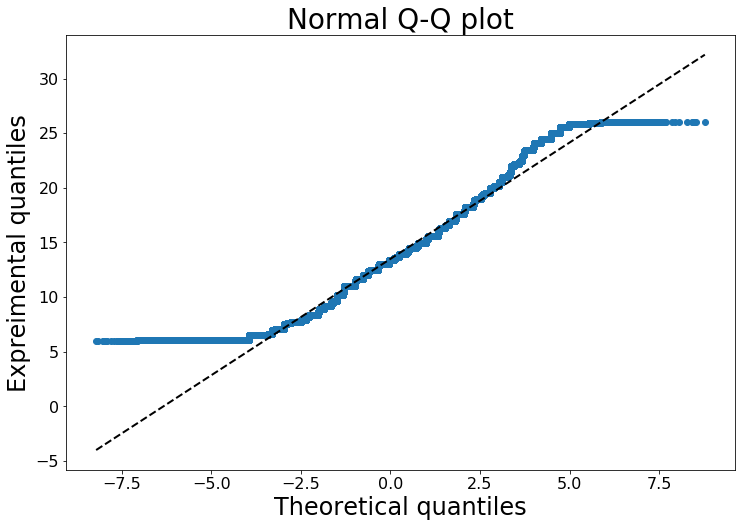

In [81]:
import numpy as np
import numpy.random as random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data=list(df.int_rate)
data.sort()
norm=random.normal(0,2,len(data))
norm.sort()
plt.figure(figsize=(12,8),facecolor='1.0') 

plt.plot(norm,data,"o")


z = np.polyfit(norm,data, 1)
p = np.poly1d(z)
plt.plot(norm,p(norm),"k--", linewidth=2)
plt.title("Normal Q-Q plot", size=28)
plt.xlabel("Theoretical quantiles", size=24)
plt.ylabel("Expreimental quantiles", size=24)
plt.tick_params(labelsize=16)
plt.show()

In [82]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle, class_weight
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [83]:
#CORRELATION

corr = df.corr(method = 'spearman')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1)
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr.correlation > 0.4]

,level_0,level_1,correlation
479,fico_range_high,fico_range_low,1.000000
814,norm_int_rate,int_rate,1.000000
817,norm_int_rate,sub_grade,0.992542
147,sub_grade,int_rate,0.992542
149,sub_grade,grade,0.974487
87,installment,loan_amnt,0.971057
118,grade,int_rate,0.966808
816,norm_int_rate,grade,0.966808
743,pub_rec_bankruptcies,pub_rec,0.814998
626,total_acc,open_acc,0.668676


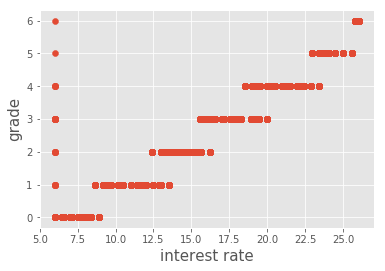

In [84]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
y=df['grade']
x=df['int_rate']
plt.scatter(x,y)
plt.ylabel('grade',fontsize=15)
plt.xlabel('interest rate',fontsize=15)
plt.show()

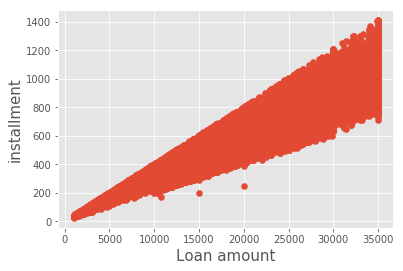

In [85]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
y=df['installment']
x=df['loan_amnt']
plt.scatter(x,y)
plt.ylabel('installment',fontsize=15)
plt.xlabel('Loan amount',fontsize=15)
plt.show()

In [86]:
#LINEAR REGRESSION

import numpy as np 
import matplotlib.pyplot as plt
from math import sqrt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as RMSE

Coefficients: 
 [0.29411718]
RMSE: 0.11


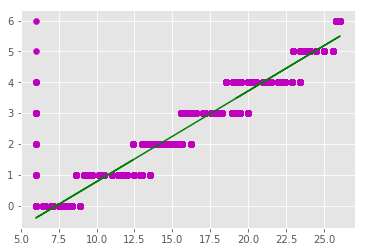

In [87]:
#using python in built functions

def linear_regression(x, y):
    x = [[i] for i in x]
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(x, y)
    
    #prediction 
    y_preds = regr.predict(x)
    
    print('Coefficients: \n', regr.coef_)
    print("RMSE: %.2f" % RMSE(y, y_preds))
    
    plt.scatter(x, y,  color='m')
    plt.plot(x, y_preds, color='g')
    plt.show()
    
x = df['int_rate']
y = df['grade'] 
linear_regression(x, y)

Coefficients: 
 [0.02881583]
RMSE: 5139.60


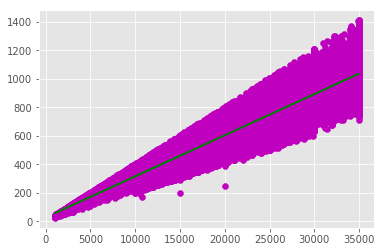

In [88]:
#using python in built functions

def linear_regression(x, y):
    x = [[i] for i in x]
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(x, y)
    
    #prediction 
    y_preds = regr.predict(x)
    
    print('Coefficients: \n', regr.coef_)
    print("RMSE: %.2f" % RMSE(y, y_preds))
    
    plt.scatter(x, y,  color='m')
    plt.plot(x, y_preds, color='g')
    plt.show()
    
x = df['loan_amnt']
y = df['installment'] 
linear_regression(x, y)

In [89]:
#HYPOTHESIS TESTING

#Two sided Hypothesis Testing for interest rate

#Population parameters
df.int_rate.mean()

13.493559837341309

In [90]:
#Population Standard Deviation
df.int_rate.std()

4.3215227127075195

In [91]:
#Taking a random sample of 1000 from a different year we get mean as:
#   MEAN OF RANDOM SAMPLE OF 2017Q1 = 13.455 

In [92]:
import scipy.stats as st
from math import sqrt



def two_sided_hypo(sample_mean, pop_mean, std_dev, sample_size, alpha):
    z = (sample_mean - pop_mean) / (std_dev/sqrt(sample_size))
    print(z)
    p_value = st.norm.sf(abs(z))*2
    print(p_value)
    if p_value <0.05:
         print('Reject NULL Hypothesis')
    else:
         print('Failed to reject NULL Hypothesis')
    

alpha = 0.05
sample_mean = 13.455
pop_mean = 13.49355
sample_size =  1000
std_dev = 4.322

print('H0 : μ >=', pop_mean)
print('H1 : μ <', pop_mean)
print('alpha value is :', alpha, '\n')

reject = two_sided_hypo(sample_mean, pop_mean, std_dev, sample_size, alpha)

H0 : μ >= 13.49355
H1 : μ < 13.49355
alpha value is : 0.05 

-0.28205877787943867
0.7778984408822767
Failed to reject NULL Hypothesis


In [93]:
# IDS 3rd SEM SECTION:B 
# Project Made BY:
# KESHAV KUMAR PES2201800207
# SHIVAM SINGH RAWAT PES2201800095
# PARTHA PRATIM MISHRA PES2201800366

# PES UNIVERSITY ELECTRONIC CITY CAMPUS